### 预处理

In [1]:
import pandas as pd
import os
from itertools import chain

isnull = lambda x : True if len(str(x).strip())==0 \
                or (str(x).lower() in ['nan', 'none', r'\N', r'\n'])   \
                else False
                
notnull = lambda x : False if isnull(x) else True
extend_list = lambda x : list(chain(*x))

def all_chinese(ss):
    for s in ss:
        if not((s >= u'\u4e00' and s<=u'\u9fa5')):
                return False
    return True

def read_txt(path, line_split=True):
    try:
        with open(path, encoding = 'utf-8') as f:
            l = [x.strip() for x in f.readlines() if len(x.strip())!=0]
    except:
        with open(path, encoding='gbk') as f:
            l = [x.strip() for x in f.readlines() if len(x.strip())!=0]
    
    if line_split:
        return l
    else:
        return [' '.join(l)]


def have_chinese(ss):
    for s in ss:
        if s >= u'\u4e00' and s<=u'\u9fa5':
                return True
    return False 

def word_filter(s):
    if s in setword_mine:
        return True
    if len(s)<2:
        return False
    
    if not all_chinese(s.replace(' ', '')):
        return False
    return True
def remove_aite(text):
    # 删除空格
    import re
    text = re.sub(r"@[^\s]*\s", "", text)
    text = re.sub(r"@[^\s]*$", "", text)
    text = re.sub(r"#[^#]*#", "", text)
    text = re.sub(r"【[^】【]*】", "", text)

    return text

OUTPUT_DIR = r"结果"
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

stopwords = read_txt(r"stopwords.txt")
setword_mine = [x.lower() for x in read_txt(r"setwords.txt")]

import jieba
for w in setword_mine:
    jieba.add_word(w)
tokenizer = lambda x: [xx for xx in jieba.cut(str(x).lower()) if len(xx.strip())>0 and word_filter(xx.strip()) and (xx.strip() not in stopwords)]



In [2]:
import os
import pandas as pd
import datetime
import re

df = pd.read_excel(r"data/weibo.xlsx")
df['text'] = df['博文内容']

In [3]:
def remove_whitespace(text):
    # 删除空格
    import re
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\[[^\]\][\]]*\]", "", text)

    return text

def DBC2SBC(ustring):
    # 全角转半角
    rstring = ""
    for uchar in ustring:
        inside_code = ord(uchar)
        if inside_code == 0x3000:
            inside_code = 0x0020
        else:
            inside_code -= 0xfee0
        if not (0x0020 <= inside_code and inside_code <= 0x7e):
            rstring += uchar
            continue
        rstring += chr(inside_code)
    return rstring

# 大写转小写
df['text'] = df.apply(lambda x : str(x['text']).strip().lower().replace('展开c', ''), axis=1)

# 全角转半角
df['text']  = df.apply(lambda x : DBC2SBC(x['text']), axis=1)

# 删除多余空格
df['text'] = df.apply(lambda x : remove_aite(remove_whitespace(x['text'])), axis=1)


def filter_text(s):
    if len(s.strip())<6:
        return False
    if not have_chinese(s.strip()):
        return False
    return True

df['flag'] = df.apply(lambda x :filter_text(x['text']), axis=1)
df = df[df['flag'] ]

df = df.drop('flag', axis=1)
list_text = list((df['text']))
print(len(list_text))


# df.to_excel("数据.xlsx", index=False)

1175


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\bangb\AppData\Local\Temp\jieba.cache
Loading model cost 0.415 seconds.
Prefix dict has been built successfully.
d:\software\anaconda\envs\text_cpu\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['佩罗', '品牌', '大面儿', '抗拒', '敞开', '毫无保留', '目前为止', '策略', '贸易', '赶早', '赶晚', '限时', '风格'] not in stop_words.
  % sorted(inconsistent)


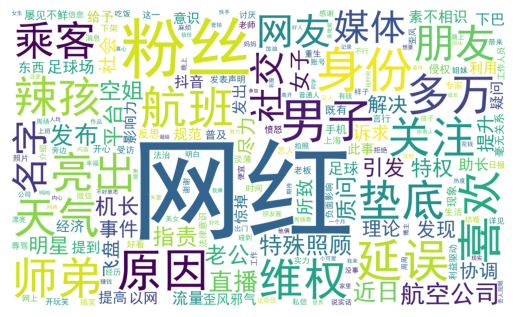

In [4]:
# 词频
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.colors as colors


cv = CountVectorizer(analyzer='word', tokenizer=tokenizer, stop_words=stopwords, ngram_range=(1, 1), binary=True)
fre_matrix = cv.fit_transform(list_text).toarray()
fre_matrix = np.sum(fre_matrix, axis=0).tolist()
word_fre = [[x, y] for x,y in zip(cv.get_feature_names_out(), fre_matrix)]
dict_word_fre = {x:y for x,y in word_fre}
df_wordfre = pd.DataFrame(word_fre, columns=['单词', '频次'])
df_wordfre = df_wordfre.sort_values(by='频次', ascending=False)

df_wordfre['flag'] = df_wordfre.apply(lambda x :word_filter(x['单词']), axis=1)
df_wordfre = df_wordfre[df_wordfre['flag'] ]
df_wordfre = pd.DataFrame(df_wordfre, columns=['单词', '频次'])
df_wordfre.to_excel(os.path.join(OUTPUT_DIR, '词频统计.xlsx'), index=False)

dict_word_fre = {x:y for x, y in zip(list(df_wordfre['单词']), list(df_wordfre['频次']))}
my_cloud = WordCloud(width=1000, height=600, max_words=200, 
                    background_color='white', font_path='simhei.ttf', random_state=50
    ).generate_from_frequencies(dict_word_fre)
my_cloud.to_file(os.path.join(OUTPUT_DIR, '词频词云图.png'))

plt.imshow(my_cloud)
plt.axis("off")
plt.show()



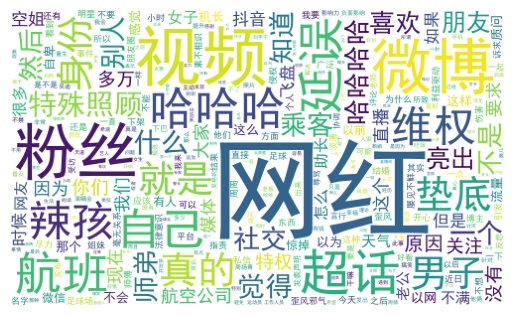

In [5]:
# tfidf
import jieba.analyse
import matplotlib.pyplot as plt


topk = 10000
word_tfidf = jieba.analyse.extract_tags(' '.join(list_text), topK=topk, withWeight=True)
word_tfidf = [[x[0], x[1]] for x in word_tfidf]
dict_word_tfidf = {x:y for x,y in word_tfidf}
df_wordtfidf = pd.DataFrame(word_tfidf, columns=['单词', 'tfidf'])
df_wordtfidf = df_wordtfidf.sort_values(by='tfidf', ascending=False)

df_wordtfidf['flag'] = df_wordtfidf.apply(lambda x :word_filter(x['单词']), axis=1)
df_wordtfidf = df_wordtfidf[df_wordtfidf['flag'] ]
df_wordtfidf = pd.DataFrame(df_wordtfidf, columns=['单词', 'tfidf'])
df_wordtfidf.to_excel(os.path.join(OUTPUT_DIR, '单词tfidf.xlsx'), index=False)

dict_word_tfidf = {x:y for x, y in zip(list(df_wordtfidf['单词']), list(df_wordtfidf['tfidf']))}
my_cloud = WordCloud(width=500, height=300, max_words=300,
    background_color='white', font_path='simhei.ttf', random_state=50
    ).generate_from_frequencies(dict_word_tfidf)
my_cloud.to_file(os.path.join(OUTPUT_DIR, 'tfidf词云图.png'))

plt.imshow(my_cloud)
plt.axis("off")
plt.show()

### 情感分析

In [12]:
import re
import requests
import json


API_KEY = ""
SECRET_KEY = ""

def get_access_token():
    """
    使用 AK，SK 生成鉴权签名（Access Token）
    :return: access_token，或是None(如果错误)
    """
    url = "https://aip.baidubce.com/oauth/2.0/token"
    params = {"grant_type": "client_credentials", "client_id": API_KEY, "client_secret": SECRET_KEY}
    return str(requests.post(url, params=params).json().get("access_token"))


token = get_access_token()

def get_emotion( data):  # 情感分析
    # 定义百度API情感分析的token值和URL值
    url = 'https://aip.baidubce.com/rpc/2.0/nlp/v1/sentiment_classify?charset=UTF-8&access_token={}'.format(token)
 
    new_each = {
        'text': data  # 将文本数据保存在变量new_each中，data的数据类型为string
    }
    new_each = json.dumps(new_each)
    res = requests.post(url, data=new_each)  # 利用URL请求百度情感分析API
    # print("content: ", res.content)
    res_text = res.text  # 保存分析得到的结果，以string格式保存
    result = res_text.find('items')  # 查找得到的结果中是否有items这一项
    positive = 1
    if (result != -1):  # 如果结果不等于-1，则说明存在items这一项
        json_data = json.loads(res.text)
        negative = (json_data['items'][0]['negative_prob'])  # 得到消极指数值
        positive = (json_data['items'][0]['positive_prob'])  # 得到积极指数值
        confidence = (json_data['items'][0]['confidence'])
        sentiment = (json_data['items'][0]['sentiment'])
    else:
        positive, negative, confidence, sentiment = 0, 0, 0, 404
    return positive, negative, sentiment

import time

with open('data.json', encoding='utf-8-sig') as jsonfile:
    dict_already = json.load(jsonfile)

list_res = []

count = 0
for text in list(df['text']):
    print(count)
    if count%100==0:
        with open('data.json', 'w') as outfile:
            json.dump(dict_already, outfile)
    try:
        text = str(text)[:1024]
        count += 1
        if (dict_already.get(text, [404])[-1] not in [0, 1, 2]) or len(dict_already.get(text, [404]))!=3:
            positive, negative, sentiment = get_emotion(text)
            dict_already[text] = [positive, negative, sentiment ]
            time.sleep(0.5)
            list_res.append([positive, negative,  sentiment ])

        else:
            list_res.append(dict_already[text])


    except:
        print(text)
        list_res.append([0, 0, 0, 404])

with open('data.json', 'w') as outfile:
    json.dump(dict_already, outfile)
    
df['positive'] = [x[0] for x in list_res]
df['negative'] = [x[1] for x in list_res]
df['sentiment'] = [x[2] for x in list_res]


ddds = {1:'neu', 2:'pos', 0:'neg'}
df['情感极性'] = df.apply(lambda x: ddds.get(x['sentiment'], ''), axis=1)

def sss(x):
    if x['情感极性']=='neu':
        return 0
    elif x['情感极性']=='neg':
        return -x['negative']
    elif x['情感极性']=='pos':
        return x['positive']
df['情感得分'] = df.apply(lambda x: sss(x), axis=1)


df.to_excel(os.path.join(OUTPUT_DIR, '情感分析结果.xlsx'), index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
from pyecharts.charts import Pie
import pyecharts.options as opts
dict_d = {}
for x in set(list(df['情感极性'])):
    dict_d[x] = len(df[df['情感极性']==x])
    
data = [[k, v] for k, v in dict_d.items()]

p = (
        Pie()  # 实例化
        .add(
            series_name="情感分布",  # 系列名称
            data_pair=data,# 馈入数据
            radius="35%",            # 饼图半径比例
            center=["50%", "50%"],   # 饼图中心坐标
            label_opts=opts.LabelOpts(is_show=False, position="center"),  # 标签位置
        )
        .set_global_opts(
                title_opts=opts.TitleOpts(
                title="情感极性分布",    # 标题
                pos_left="center",         # 标题水平位置
                pos_top="100",              # 标题与画布顶端距离
                ),
                legend_opts=opts.LegendOpts(is_show=False))
        .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))).render(os.path.join(OUTPUT_DIR, "情感饼图.html")) 



In [15]:
df_word_sen = pd.read_excel(r"pretrain_zh\情感词典.xlsx")

df_word_sen = df_word_sen.drop_duplicates(subset=['word'], keep='first')

dict_word_sen = {k:1 if v==1 else -1 for k, v in dict(zip(df_word_sen['word'], df_word_sen['polarity'])).items()}

list_neg = set([x.strip() for x in list(set(df_word_sen[df_word_sen['polarity']==-1]['word'])) if (len(x.strip())>1) and (word_filter(x.strip()))])
list_pos = set([x.strip() for x in list(set(df_word_sen[df_word_sen['polarity']==1]['word'])) if (len(x.strip())>1) and (word_filter(x.strip()))])

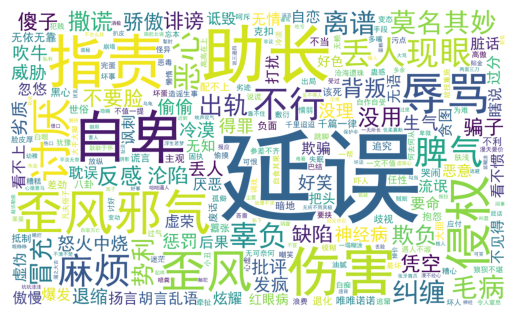

In [16]:
# 词频
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.colors as colors


cv = CountVectorizer(analyzer='word', tokenizer=tokenizer, stop_words=['身后', '疯狂', '九尾狐', '刺激', '开心', '包子', '大爷', '清淡','开玩笑','东西','不到', '随便', '活动', '老马', '屁股', '不太', '厉害', '不好意思', '黄色', '一点点'], vocabulary=list(list_neg), ngram_range=(1, 1))
fre_matrix = cv.fit_transform(list_text).toarray()
fre_matrix = np.sum(fre_matrix, axis=0).tolist()
word_fre = [[x, y] for x,y in zip(cv.get_feature_names_out(), fre_matrix)]
dict_word_fre = {x:y for x,y in word_fre}
df_wordfre = pd.DataFrame(word_fre, columns=['单词', '频次'])
df_wordfre = df_wordfre.sort_values(by='频次', ascending=False)

df_wordfre['flag'] = df_wordfre.apply(lambda x :word_filter(x['单词']), axis=1)
df_wordfre = df_wordfre[df_wordfre['flag'] ]

df_wordfre = pd.DataFrame(df_wordfre, columns=['单词', '频次'])
df_wordfre.to_excel(os.path.join(OUTPUT_DIR, '消极词频统计.xlsx'), index=False)


dict_word_fre = {x:y for x, y in zip(list(df_wordfre['单词']), list(df_wordfre['频次'])) }
my_cloud = WordCloud(width=1000, height=600, max_words=300, 
                    background_color='white', font_path='simhei.ttf', random_state=50
    ).generate_from_frequencies(dict_word_fre)
my_cloud.to_file(os.path.join(OUTPUT_DIR, '消极词频词云图.png'))

plt.imshow(my_cloud)
plt.axis("off")
plt.show()



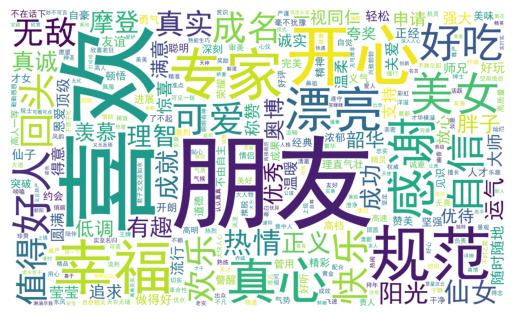

In [17]:
# 词频
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.colors as colors


cv = CountVectorizer(analyzer='word', tokenizer=tokenizer, stop_words=['人物', '真真', '确实', '随便', '机会', '特别', '花哨', '廉价', '刻意'], vocabulary=list(list_pos), ngram_range=(1, 1))
fre_matrix = cv.fit_transform(list_text).toarray()
fre_matrix = np.sum(fre_matrix, axis=0).tolist()
word_fre = [[x, y] for x,y in zip(cv.get_feature_names_out(), fre_matrix)]
dict_word_fre = {x:y for x,y in word_fre}
df_wordfre = pd.DataFrame(word_fre, columns=['单词', '频次'])
df_wordfre = df_wordfre.sort_values(by='频次', ascending=False)

df_wordfre['flag'] = df_wordfre.apply(lambda x :word_filter(x['单词']), axis=1)
df_wordfre = df_wordfre[df_wordfre['flag'] ]

df_wordfre = pd.DataFrame(df_wordfre, columns=['单词', '频次'])
df_wordfre.to_excel(os.path.join(OUTPUT_DIR, '积极词频统计.xlsx'), index=False)

dict_word_fre = {x:y for x, y in zip(list(df_wordfre['单词']), list(df_wordfre['频次']))}
my_cloud = WordCloud(width=1000, height=600, max_words=300, 
                    background_color='white', font_path='simhei.ttf', random_state=50
    ).generate_from_frequencies(dict_word_fre)
my_cloud.to_file(os.path.join(OUTPUT_DIR, '积极词频词云图.png'))

plt.imshow(my_cloud)
plt.axis("off")
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

df_wordfre = pd.read_excel(r'结果/消极词频统计_翻译.xlsx')


dict_word_fre = {x:y for x, y in zip(list(df_wordfre['翻译']), list(df_wordfre['频次'])) }
my_cloud = WordCloud(width=1000, height=600, max_words=200, 
                    background_color='white', font_path='simhei.ttf', random_state=50
    ).generate_from_frequencies(dict_word_fre)
my_cloud.to_file(os.path.join(OUTPUT_DIR, '消极词频词云图_翻译.png'))

plt.imshow(my_cloud)
plt.axis("off")
plt.show()